In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans
from ahaco import run_ahaco

## AHACO Impl

In [3]:
"""
    Inverse distance - Get an array of inverted distances
    @arg
        {numpy.ndarray} space   -- The space

    @return
        {numpy.ndarray}         -- A space.dimension per space.dimension array of inverse distances
"""
def inverse_distances(space):
    # Empty multidimensional array (matriz) to distances
    distances = np.zeros((space.shape[0], space.shape[0]))

    # Calculate distance to all nodes to all nodes
    for index, point in enumerate(space):
        distances[index] = np.sqrt(((space - point) ** 2).sum(axis = 1))

    # Floating-point error handling - Setted to known state
    with np.errstate(all = 'ignore'):
        # Invert the distances
        inv_distances = 1 / distances

    # Replace infinity by zero to prevent zero division error
    inv_distances[inv_distances == np.inf] = 0

    # Eta algorithm result, inverted distances
    return distances, inv_distances

def get_centroid_cluster_num(citynum):
    if citynum > 125:
        return math.floor(citynum / 25)
    elif citynum < 4:
        return citynum
    else:
        return 4

"""
    Initialize ants - Get an array of random initial positions of the ants in space
    @arg
        {numpy.ndarray} space   -- The space
        {int} colony            -- Number of ants in the colony

    @return
        {numpy.ndarry}          -- An array of indexes of initial positions of ants in the space
"""
def initialize_ants(space, colony):
    # Indexes of initial positions of ants
    return np.random.randint(space.shape[0], size = colony)

def calculate_Euclidean_distance(point_1, point_2):
    return np.linalg.norm(point_1 - point_2)

def calculate_cost_fitness(path : list, space : np.ndarray):
    rs = 0
    path_len = len(path)
    for i in range(0, path_len - 1):
        rs = rs + calculate_Euclidean_distance(space[path[i]], space[path[i + 1]])
    rs = rs + calculate_Euclidean_distance(space[path[path_len - 1]], space[path[0]])
    return rs

def perform_two_opt_algorithm(path:np.ndarray, space:np.ndarray):
    rs_path = path.copy()
    for i in range(len(rs_path) - 3):
        if calculate_Euclidean_distance(space[rs_path[i]], space[rs_path[i + 1]]) + calculate_Euclidean_distance(space[rs_path[i + 2]], space[rs_path[i + 3]])\
            > calculate_Euclidean_distance(space[rs_path[i]], space[rs_path[i + 2]]) + calculate_Euclidean_distance(space[rs_path[i + 1]], space[rs_path[i + 3]]):
            print(i)
            temp = rs_path[i + 1]
            rs_path[i + 1] = rs_path[i + 2]
            rs_path[i + 2] = temp
    return rs_path

def convert_path_to_matrix(path : np.ndarray, space : np.ndarray):
    ## This will return matrix that A[i,j] = 1 if i,j in on tour of path ##
    rs = np.zeros((space.shape[0], space.shape[0]))
    for i in range(len(path) - 1):
        rs[path[i], path[i + 1]] = 1
        rs[path[i + 1], path[i]] = 1
    return rs

In [4]:
### INITIALIZE HYPER PARAMETERS ###
# Number of interation
t_max = 1000 
# Population size (number of ant)
pop_size = 10
#
tries = t_max / 10
# alpha
alpha = 1.0
# beta 
beta = 3.0
# Seperation factor
seperation_factor = 1.5
# Maximum reward-punish factor
max_reward_punish_factor = 8
# Evaporation coeIcient
p = 0.9
# Initialized pheromone
pheromones = np.ones((space.shape[0], space.shape[0]))
# total ammount of pheronome
Q = 120

In [14]:
## Calculate Euclidean distance for the cities and get the number of cities as citynum ##
citynum = space.shape[0]
   # inverted distance and distance
distances, inverted_distance = inverse_distances(space)

## Initialize pheromone ##
pheromones = np.ones((space.shape[0], space.shape[0]))

# ## Number of ants ##
# ants_colony = 15

## Apply k-means clustering for the cities ## Equation 7 to 10 (using Kmeans library)
# define number of centorids
k = get_centroid_cluster_num(citynum) 
kmeans = KMeans(n_clusters=k, random_state=0, max_iter=500).fit(space)
cluster_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_
centroid_distance = kmeans.transform(space) ## Get distance from each city to centroid
data = np.append(space.copy(), np.expand_dims(cluster_labels, axis=1), axis=1) # x, y, cluster_no
data = np.append(data.copy(), np.expand_dims(np.min(centroid_distance, axis=1), axis=1), axis=1) # x, y, cluster_no, distance_to_centroid

## Seperate non-classified cities ## ## Equation 11
city_class_realtion = np.zeros((space.shape[0], space.shape[0]))
for i in range(cluster_centers.shape[0]):
   cluster = cluster_centers[i]
   element_index = np.where(data[:, 2] == i)
   element = data[element_index][:, 3]
   element_std = np.std(element)
   element_mean = np.mean(element)
   for i in element_index[0]:
      element_distance = data[i, 3]
      if element_std != 0 and element_distance - element_mean >= seperation_factor * element_std:
         data[i, 2] = -1 # Define this city is classless
# define city class relation
class_relation = np.expand_dims(data[:,2], axis = 1) - np.expand_dims(data[:,2], axis = 0)
class_relation = (class_relation == 0).astype(int)
class_relation = np.where(class_relation == 0, -1, class_relation)
classless_indices = np.where(data[:, 2] == -1)
for classless_index in classless_indices:
   class_relation[classless_index, :] = 0
   class_relation[:, classless_index] = 0
for i in range(space.shape[0]):
   class_relation[i,i] = 0

## Initialize ant position ##
ant_positions = initialize_ants(space, pop_size)
ant_positions.dtype = np.int32

In [15]:
cluster_labels

array([0, 0, 0, 0, 0, 2, 1, 2, 2, 1, 1, 0, 2, 2, 3, 2, 2])

In [16]:
print(class_relation)

[[ 0  1  1  1  1 -1 -1 -1  0 -1 -1  1 -1 -1 -1 -1 -1]
 [ 1  0  1  1  1 -1 -1 -1  0 -1 -1  1 -1 -1 -1 -1 -1]
 [ 1  1  0  1  1 -1 -1 -1  0 -1 -1  1 -1 -1 -1 -1 -1]
 [ 1  1  1  0  1 -1 -1 -1  0 -1 -1  1 -1 -1 -1 -1 -1]
 [ 1  1  1  1  0 -1 -1 -1  0 -1 -1  1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1  0 -1  1  0 -1 -1 -1  1  1 -1  1  1]
 [-1 -1 -1 -1 -1 -1  0 -1  0  1  1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1  1 -1  0  0 -1 -1 -1  1  1 -1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [-1 -1 -1 -1 -1 -1  1 -1  0  0  1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1  1 -1  0  1  0 -1 -1 -1 -1 -1 -1]
 [ 1  1  1  1  1 -1 -1 -1  0 -1 -1  0 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1  1 -1  1  0 -1 -1 -1  0  1 -1  1  1]
 [-1 -1 -1 -1 -1  1 -1  1  0 -1 -1 -1  1  0 -1  1  1]
 [-1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1  1 -1  1  0 -1 -1 -1  1  1 -1  0  1]
 [-1 -1 -1 -1 -1  1 -1  1  0 -1 -1 -1  1  1 -1  1  0]]


In [12]:
print(class_relation)

[[ 0  1  1  1  1 -1 -1 -1  0 -1 -1  1 -1 -1 -1 -1 -1]
 [ 1  0  1  1  1 -1 -1 -1  0 -1 -1  1 -1 -1 -1 -1 -1]
 [ 1  1  0  1  1 -1 -1 -1  0 -1 -1  1 -1 -1 -1 -1 -1]
 [ 1  1  1  0  1 -1 -1 -1  0 -1 -1  1 -1 -1 -1 -1 -1]
 [ 1  1  1  1  0 -1 -1 -1  0 -1 -1  1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1  0 -1  1  0 -1 -1 -1  1  1 -1  1  1]
 [-1 -1 -1 -1 -1 -1  0 -1  0  1  1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1  1 -1  0  0 -1 -1 -1  1  1 -1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [-1 -1 -1 -1 -1 -1  1 -1  0  0  1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1  1 -1  0  1  0 -1 -1 -1 -1 -1 -1]
 [ 1  1  1  1  1 -1 -1 -1  0 -1 -1  0 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1  1 -1  1  0 -1 -1 -1  0  1 -1  1  1]
 [-1 -1 -1 -1 -1  1 -1  1  0 -1 -1 -1  1  0 -1  1  1]
 [-1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1  1 -1  1  0 -1 -1 -1  1  1 -1  0  1]
 [-1 -1 -1 -1 -1  1 -1  1  0 -1 -1 -1  1  1 -1  1  0]]


In [9]:
## Define ant_path: this is optimal solution for each ant
ant_path = np.zeros((pop_size, citynum), dtype=np.int32)
last_best_ant_path = np.zeros((pop_size, citynum), dtype=np.int32)
fitness_array = np.zeros((pop_size, 1))
best_ant_path = None
best_fitness = float('inf')
times = 0
delta_reward_punish_factor = 2 * (max_reward_punish_factor - 1) / t_max
reward_punish_factor = max_reward_punish_factor
probability_matrix = np.zeros((space.shape[0], space.shape[0], pop_size)) # (order, city_list, ant_size))

for iteration in range(1, t_max):
   if iteration < (t_max / 2):
      reward_punish_factor = reward_punish_factor - delta_reward_punish_factor
      Y = -1
   else:
      reward_punish_factor = reward_punish_factor + delta_reward_punish_factor
      Y = 1
   for k in range(pop_size): # Travesre in all ants
      location_prob = probability_matrix[:, :, k] # Get location matrix of ith ant
      # print(f"Location prob {location_prob.shape}")
      # print(f"process ant number {k}")
      for j in range(citynum): # Traverse cities in order ()
         # print(f"traverse {j}")
         if j == 0: # process Starting point
            # print("starting point")
            ant_starting_position = ant_positions[k]
            one_hot = np.zeros(citynum)
            one_hot[ant_starting_position] = 1
            location_prob[j] = one_hot
            ant_path[k][j] = ant_starting_position
         else:
            allowed_k = np.ones(citynum)
            allowed_k[ant_path[k, 0:j]] = 0
            last_location =  ant_path[k][j - 1]

            if k % 2 == 1 : ## Special ant
               ## Calculate with equation (13)
               next_location_prob = (pheromones[last_location, :] * (inverted_distance[last_location, :] ** 3) * (reward_punish_factor ** (Y * class_relation[last_location, :]))) * allowed_k
               next_location_prob = next_location_prob / np.sum(next_location_prob)
               location_prob[j] = next_location_prob
               ## Getting nearest city index base on next_location_prob and assign it to next location
               nearest_city = np.argmax(next_location_prob)
               ant_path[k, j] = nearest_city
               # break
               pass
            else: ## Normal ant
               ## Calculate with equation (2)
               next_location_prob = (pheromones[last_location, :] ** alpha) * (inverted_distance[last_location, :] ** beta) * allowed_k 
               next_location_prob = next_location_prob / np.sum(next_location_prob)
               location_prob[j] = next_location_prob
               ## Getting nearest city index base on next_location_prob and assign it to next location
               nearest_city = np.argmax(next_location_prob)
               ant_path[k, j] = nearest_city
               # break
      # Calculate fitness of the corresponding solution obtained by ant i (equation (1))
      fitness_array[k] = calculate_cost_fitness(path=ant_path[k,:].tolist(), space=space)

      # break
   ## Select the best solution of all ants AND update global best solution (optimal solution)##
   best_ant_path = ant_path[np.argmin(fitness_array)]
   best_fitness = np.amin(fitness_array)

   ## Apply improved 2-opt algorithm to optimal solution (Section 3.3) ##
   if len(best_ant_path) >= 4:
      best_ant_path = perform_two_opt_algorithm(best_ant_path, space)
      best_fitness = calculate_cost_fitness(best_ant_path.tolist(), space)
   print(f"iteration {iteration} get fitness {best_fitness}")  ## Fitness is optimal path length
   
   ## Update pheromone on normal and special best solution separately (equations (14)–(16)) ##
   min_normal_fitness_cost = fitness_array[2 * np.argmin(fitness_array[0::2])]
   min_special_fitness_cost = fitness_array[2 * np.argmin(fitness_array[1::2]) + 1]
   
   location_matrix = convert_path_to_matrix(best_ant_path, space)
   normal_delta_pheromone = location_matrix.copy() * (Q / min_normal_fitness_cost)
   special_delta_pheromone = location_matrix.copy() * (Q / min_special_fitness_cost)
   delta_pheromone = normal_delta_pheromone + special_delta_pheromone

   pheromones = (1 - p) * pheromones + delta_pheromone

   ## If global best solution is not updated ##
   if np.array_equal(best_ant_path, last_best_ant_path):
      times = times + 1
      if times > tries:
         # Re-initialize the pheromone on the global best solution
         pheromones = np.ones((space.shape[0], space.shape[0]))
         times = 0
   else:
      times = 0
   last_best_ant_path = best_ant_path
         
   # break

iteration 1 get fitness 248.9481158101162
iteration 2 get fitness 248.9481158101162
iteration 3 get fitness 248.94811581011618
iteration 4 get fitness 248.94811581011618
iteration 5 get fitness 248.94811581011618
iteration 6 get fitness 248.94811581011618
iteration 7 get fitness 248.94811581011618
iteration 8 get fitness 248.94811581011618
iteration 9 get fitness 248.94811581011618
iteration 10 get fitness 248.94811581011618
iteration 11 get fitness 248.94811581011618
iteration 12 get fitness 248.94811581011618
iteration 13 get fitness 248.94811581011618
iteration 14 get fitness 248.94811581011618
iteration 15 get fitness 248.94811581011618
iteration 16 get fitness 248.94811581011618
iteration 17 get fitness 248.94811581011618
iteration 18 get fitness 248.94811581011618
iteration 19 get fitness 248.94811581011618
iteration 20 get fitness 248.94811581011618
iteration 21 get fitness 248.94811581011618
iteration 22 get fitness 248.94811581011618
iteration 23 get fitness 248.94811581011618

In [7]:
best_ant_path

array([10,  9,  6, 12,  0,  2, 11,  1,  3,  4, 15, 16,  5, 13,  7,  8, 14])

## Library testing

In [30]:
def processing(path: np.ndarray):
    start_index = np.where(path == (len(path) - 1))[0][0]
    return np.roll(path.copy(), -start_index)[1:]

In [31]:
input_path_file = "D:\\Logistic_code\\code\\vrp\\clustering\\fuzzy_c_mean\\data.csv"
dataframe = pd.read_csv(input_path_file)
data = dataframe.to_numpy()

In [32]:
depot = np.array([500, 500])
space_with_depot = np.append(data, [depot], axis=0)

In [47]:

best_ant_path, best_fitness = run_ahaco(space_with_depot)
# best_ant_path_without_depot = processing(city_index[best_ant_path])


c:\Anaconda\envs\monigate\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "
d:\Logistic_code\code\vrp\tsp\ahaco\ahaco.py:227: RuntimeWarning: divide by zero encountered in true_divide
  normal_delta_pheromone = location_matrix.copy() * (Q / min_normal_fitness_cost)
d:\Logistic_code\code\vrp\tsp\ahaco\ahaco.py:227: RuntimeWarning: invalid value encountered in multiply
  normal_delta_pheromone = location_matrix.copy() * (Q / min_normal_fitness_cost)
d:\Logistic_code\code\vrp\tsp\ahaco\ahaco.py:228: RuntimeWarning: divide by zero encountered in true_divide
  special_delta_pheromone = location_matrix.copy() * (Q / min_special_fitness_cost)
d:\Logistic_code\code\vrp\tsp\ahaco\ahaco.py:228: RuntimeWarning: invalid value encountered in multiply
  

In [34]:
best_ant_path

array([13,  7,  1, 12, 10, 14,  4,  0, 11,  8,  6, 15,  5,  3,  2,  9])

In [35]:
best_ant_path_without_depot = processing(best_ant_path.copy())


In [36]:
best_ant_path_without_depot

array([ 5,  3,  2,  9, 13,  7,  1, 12, 10, 14,  4,  0, 11,  8,  6])

In [42]:
data[best_ant_path_without_depot]

array([[969, 841],
       [959, 743],
       [983, 684],
       [943, 547],
       [829, 283],
       [936, 274],
       [890, 200],
       [849, 163],
       [789, 172],
       [618, 147],
       [569, 146],
       [615, 190],
       [632, 209],
       [650, 221],
       [607, 256]], dtype=int64)

In [37]:
for i in range(best_ant_path_without_depot.shape[0]):
    print(data[i])

[615 190]
[890 200]
[983 684]
[959 743]
[569 146]
[969 841]
[607 256]
[936 274]
[650 221]
[943 547]
[789 172]
[632 209]
[849 163]
[829 283]
[618 147]


In [43]:
def plot_points(best_ant_path: list, depot:np.ndarray, data:np.ndarray):
    figure(figsize=(14, 12), dpi=80)
    # Plot depot:
    plt.scatter(depot[0], depot[1], marker="x", c = [(1,0,0)])

    # Plot point  
    for i in range(best_ant_path.shape[0]):
        point = data[i]
        # print(cluster_color[data[3]])
        plt.scatter(point[0], point[1], marker="o", c = [(0,0,0)])
    # Plot cluster center
    # Plot route
    plt.plot(np.concatenate((np.array([depot[0]]), data[best_ant_path][:,0], np.array([depot[0]])), axis=0),
            np.concatenate((np.array([depot[1]]), data[best_ant_path][:,1], np.array([depot[1]])), axis=0))

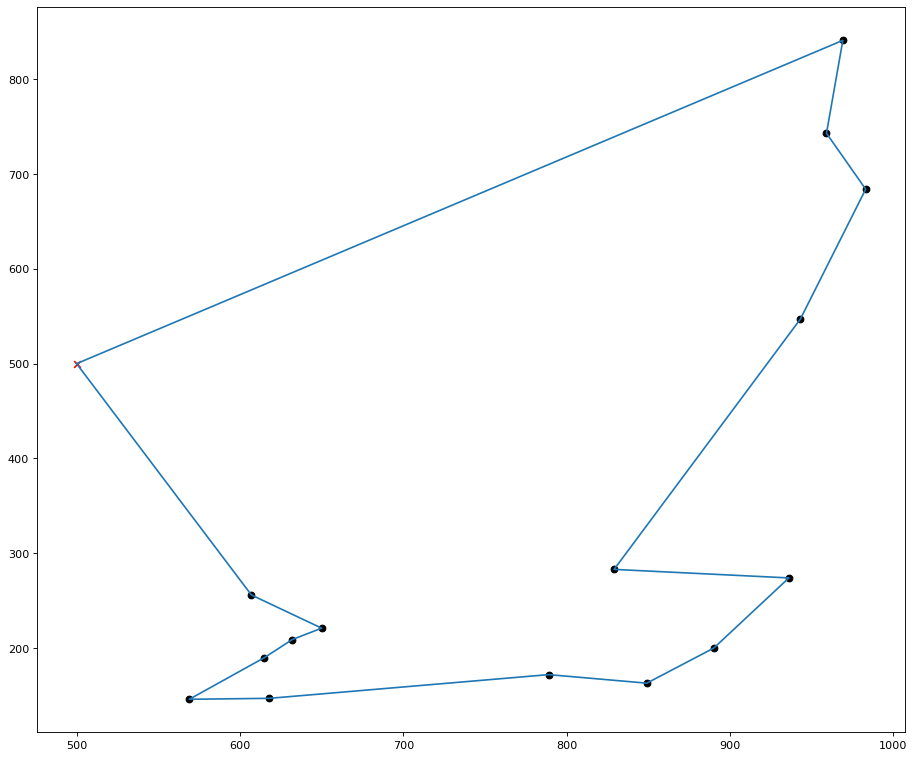

In [44]:
plot_points(best_ant_path_without_depot, depot, data)